In [1]:
import os
import numpy as np

import analysis_plotting_helper_functions_c3v3 as helper
import analysis_utils as utils
import utils_c5

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
cohort = 'cohort_5'
exp = 'exp2'
data_dir = '/Users/rebekahzhang/data/behavior_data'
data_folder = os.path.join(data_dir, cohort, exp, 'full_clean')
figure_folder = os.path.join(data_dir, cohort, exp, 'figures')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/data/behavior_data/cohort_5/exp2/full_clean
/Users/rebekahzhang/data/behavior_data/cohort_5/exp2/figures


In [3]:
# two_colors = plt.cm.viridis(np.linspace(0, 1, 2))
two_colors = ["#ffb400", "#9080ff"]
custom_palette = {'s': two_colors[0], 'l': two_colors[1]}

In [4]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", 
          "#beb9db", "#fdcce5", "#8bd3c7"]

# Session based plotting

### load session log

In [5]:
path = os.path.join(data_folder,f'sessions_training_{exp}.csv')

In [6]:
sessions_training = utils_c5.load_data(os.path.join(data_folder,f'sessions_training_{exp}.csv'))

In [7]:
sessions_training

,index,mouse,date,time,exp,training,rig,avg_tw,dir,group,num_blocks,num_trials,rewards,session_time,proper_end,session
0,54,RZ034,2024-01-30,09-52-34,2,regular,rig2,0.47,2024-01-30_09-52-34_RZ034,s,1.0,397.0,210.0,2406.21,True,0
1,55,RZ036,2024-01-30,09-55-23,2,regular,rig3,0.39,2024-01-30_09-55-23_RZ036,s,1.0,664.0,425.0,3601.08,True,0
2,56,RZ037,2024-01-30,10-36-04,2,regular,rig2,1.70,2024-01-30_10-36-04_RZ037,l,1.0,252.0,370.0,3602.47,True,0
3,57,RZ038,2024-01-30,10-59-43,2,regular,rig3,0.75,2024-01-30_10-59-43_RZ038,l,1.0,239.0,170.0,3607.86,True,0
4,58,RZ039,2024-01-30,11-40-20,2,regular,rig2,1.18,2024-01-30_11-40-20_RZ039,l,1.0,245.0,275.0,3610.05,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,670,RZ034,2024-04-15,12-42-19,2,regular,rig2,2.12,2024-04-15_12-42-19_RZ034,s,1.0,357.0,700.0,2320.38,True,56
617,671,RZ036,2024-04-15,12-43-20,2,regular,rig3,1.27,2024-04-15_12-43-20_RZ036,s,1.0,525.0,700.0,3166.65,True,56
618,672,RZ037,2024-04-15,13-23-53,2,regular,rig2,5.86,2024-04-15_13-23-53_RZ037,l,1.0,271.0,700.0,4774.87,True,56
619,673,RZ038,2024-04-15,13-39-14,2,regular,rig3,6.03,2024-04-15_13-39-14_RZ038,l,1.0,130.0,285.0,2711.29,True,56


make mouse list

In [8]:
mouse_list = utils_c5.generate_mouse_list(sessions_training)
print(mouse_list)

['RZ034', 'RZ036', 'RZ037', 'RZ038', 'RZ039']


In [9]:
cohort_group = {"s": ['RZ034', 'RZ036'], 
          "l": ['RZ037', 'RZ038', 'RZ039']}

### Plotting functions
should be moved to helper

In [10]:
def plot_each_mouse_per_line(data_df, column_name, plot_name, title, x_label, y_label, 
                             figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    for i, mouse in enumerate(mouse_list):
        session_mouse = data_df.loc[data_df.mouse == mouse]
        plt.plot(session_mouse.session, session_mouse[column_name], color=colors[i], label=mouse)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [11]:
def plot_overdays_colored_by_group(data_df, column_name, plot_name, title, x_label, y_label, 
                                   figure_folder=figure_folder, color_palette=custom_palette):
    fig = plt.figure()
    sns.lineplot(x="session",
                 y=column_name,
                 hue="group",
                 data=data_df,
                 palette=color_palette)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.ylim(1,4)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

# Plot type of trials per session

### generate trial type df for plotting
Calculate proportions of trials types and generate trial type df

In [12]:
def generate_trial_type_df(training_session_log):
    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c5.load_data(utils_c5.generate_trials_analyzed_path(data_folder, session_info))
        session_performance = helper.get_session_performance(all_trials)
        training_session_log.loc[training_session_log.dir == session_info['dir'], 
                                    ['miss_trials', 'good_trials']] = session_performance
    trial_type_df = training_session_log[['mouse', 'group', 'session', 'num_trials', 
                                            'miss_trials', 'good_trials']].copy()
    trial_type_df['p_miss'] = trial_type_df.miss_trials/trial_type_df.num_trials
    trial_type_df['p_good'] = trial_type_df.good_trials/trial_type_df.num_trials
    trial_type_df['p_accident'] = 1 - trial_type_df.p_good - trial_type_df.p_miss 
    return trial_type_df

In [13]:
trial_type_df = generate_trial_type_df(sessions_training)

### trial type combined plot

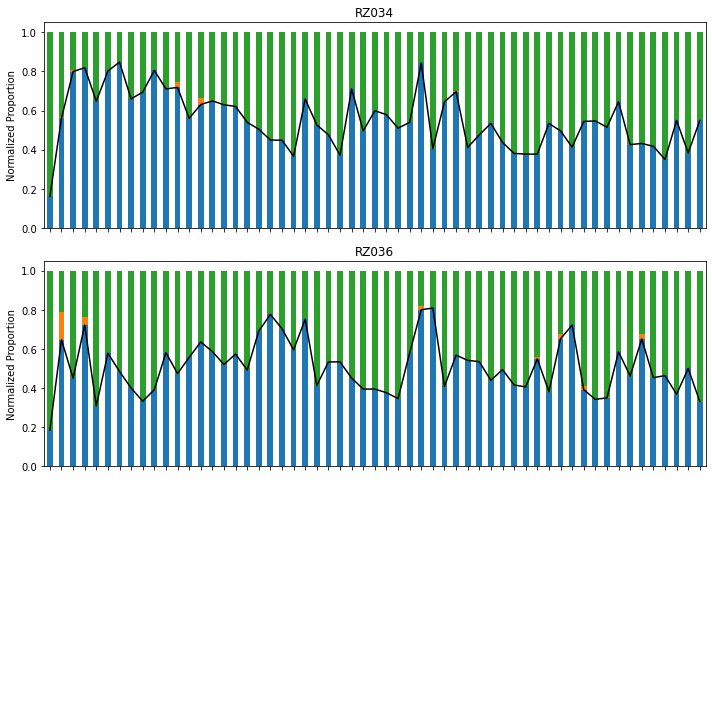

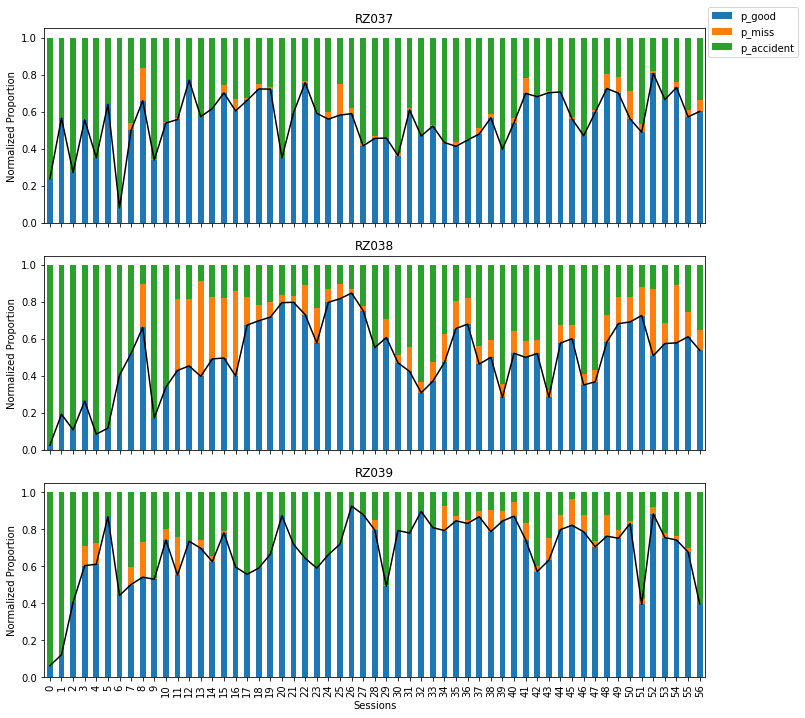

In [14]:
for group, mice in cohort_group.items():
  fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

  for i, mouse in enumerate(mice):
    session_mouse = trial_type_df.loc[(trial_type_df.mouse == mouse) & (trial_type_df.group == group)]
    to_plot = session_mouse.loc[:, ['session', 'p_good', 'p_miss', 'p_accident']]
    ax = axs.flat[i]
    to_plot.plot.bar(x='session', stacked=True, ax=ax, legend=None)
    ax.set_title(mouse)
    ax.set_xlabel('Sessions')
    ax.set_ylabel('Normalized Proportion')
    ax.plot(to_plot.session, to_plot.p_good, color='k', linewidth=1.5)
  
  if group == "l":
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
  if group == "s":
    axs.flat[2].axis('off')
  plt.tight_layout()
  plt.savefig(f'{figure_folder}/engagement_plots_{group}.png', bbox_inches='tight')

### percentage good trials

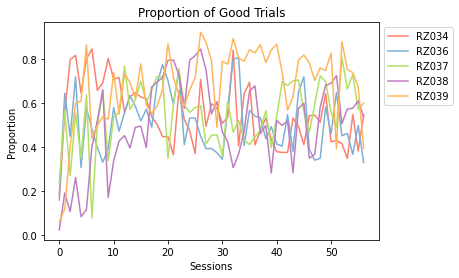

In [15]:
# plot the proportion of good trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_good', 
                         plot_name="%_good_trials", 
                         title='Proportion of Good Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

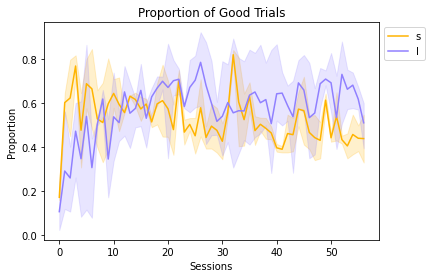

In [16]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_good", 
                               plot_name='%_good_trials_by_group', 
                               title='Proportion of Good Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent missed trials

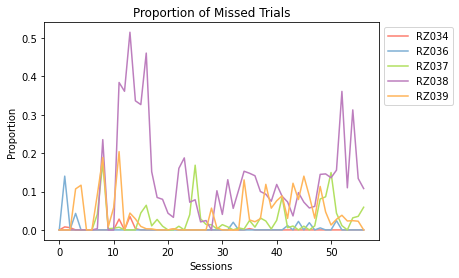

In [17]:
# plot the proportion of miss trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_miss', 
                         plot_name="%_miss_trials",
                         title='Proportion of Missed Trials', 
                         x_label='Sessions', 
                         y_label='Proportion')

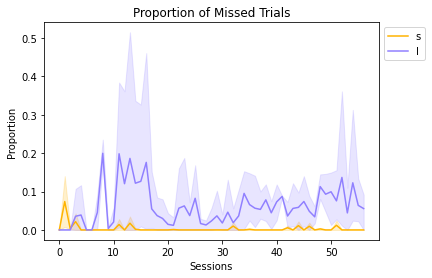

In [18]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_miss", 
                               plot_name='%_miss_trials_by_group', 
                               title='Proportion of Missed Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent accident trials

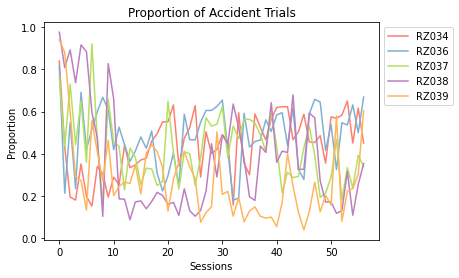

In [19]:
# plot the proportion of accident trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_accident', 
                         plot_name="%_accident_trials", 
                         title='Proportion of Accident Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

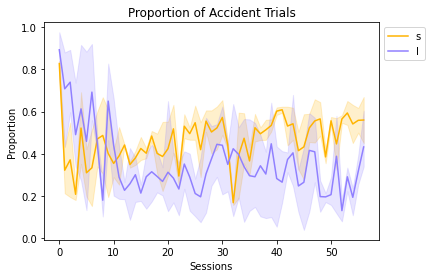

In [20]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_accident", 
                               plot_name='%_accident_trials_by_group', 
                               title='Proportion of Accident Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

# Plot rewards per session

### add info to training session log for plotting

In [21]:
sessions_training['reward_rate'] = sessions_training.rewards/sessions_training.session_time

In [22]:
sessions_training['reward_per_trial'] = sessions_training.rewards/sessions_training.num_trials

In [23]:
sessions_training['num_trials_rewarded'] = sessions_training.rewards/5

In [24]:
sessions_training['%_trials_rewarded'] = sessions_training.num_trials_rewarded/sessions_training.num_trials

### plot % rewarded trials

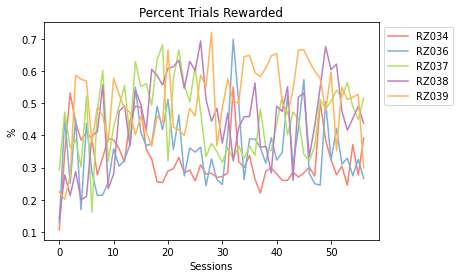

In [25]:
plot_each_mouse_per_line(data_df=sessions_training, 
                         column_name='%_trials_rewarded', 
                         plot_name="%_trials_rewarded",
                         title='Percent Trials Rewarded', 
                         x_label='Sessions', 
                         y_label='%')

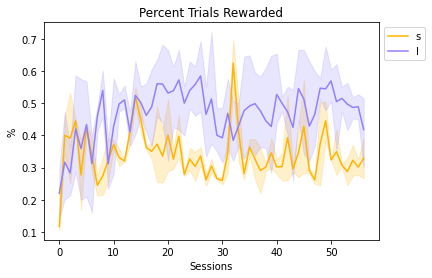

In [26]:
plot_overdays_colored_by_group(data_df=sessions_training, 
                               column_name="%_trials_rewarded", 
                               plot_name='%_trials_rewarded_by_group', 
                               title='Percent Trials Rewarded', 
                               x_label='Sessions', 
                               y_label='%')

### Plot reward rate

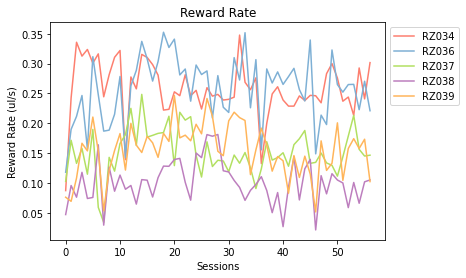

In [27]:
# plot the reward rate
plot_each_mouse_per_line(data_df=sessions_training, 
                         column_name='reward_rate', 
                         plot_name="reward_rate",
                         title='Reward Rate', 
                         x_label='Sessions', 
                         y_label='Reward Rate (ul/s)')

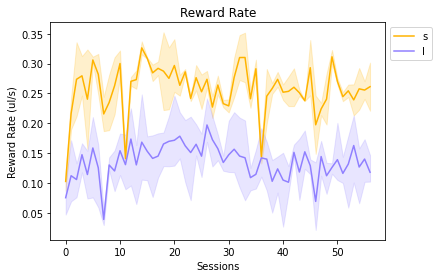

In [28]:
plot_overdays_colored_by_group(data_df=sessions_training, 
                               column_name="reward_rate", 
                               plot_name='reward_rate_by_group', 
                               title='Reward Rate', 
                               x_label='Sessions', 
                               y_label='Reward Rate (ul/s)')

### Plot session length

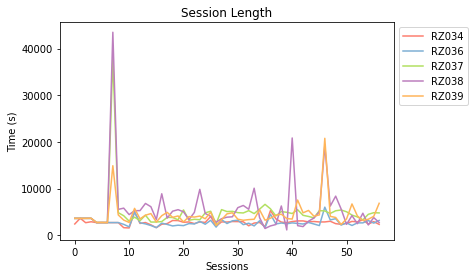

In [29]:
# plot the session length
plot_each_mouse_per_line(data_df=sessions_training, 
                         column_name='session_time', 
                         plot_name="session_length", 
                         title='Session Length',
                         x_label='Sessions', 
                         y_label='Time (s)')

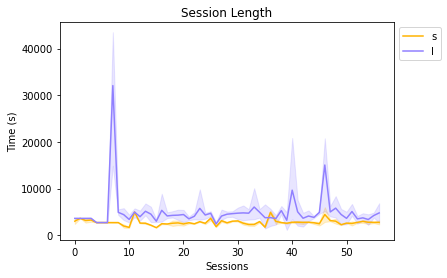

In [30]:
plot_overdays_colored_by_group(data_df=sessions_training, 
                               column_name="session_time", 
                               plot_name='session_length_by_group', 
                               title='Session Length', 
                               x_label='Sessions', 
                               y_label='Time (s)')

### plot num trials completed

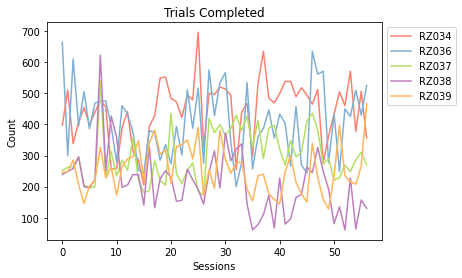

In [31]:
# plot the number of trials completed
plot_each_mouse_per_line(data_df=sessions_training, 
                         column_name='num_trials', 
                         plot_name="num_trials", 
                         title='Trials Completed',
                         x_label='Sessions', 
                         y_label='Count')

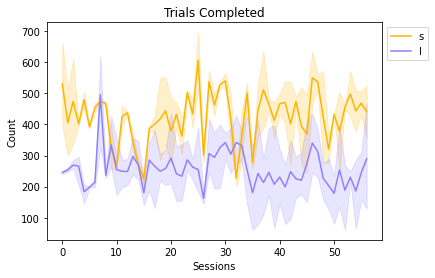

In [32]:
plot_overdays_colored_by_group(data_df=sessions_training, 
                               column_name="num_trials", 
                               plot_name='num_trials_by_group', 
                               title='Trials Completed', 
                               x_label='Sessions', 
                               y_label='Count')

# Plot background behavior

### generate mistake df for plotting

In [33]:
def get_session_mistakes(all_trials):
    all_trials['bg_repeats'] -= 1
    num_bg_repeats_mean = all_trials.bg_repeats.mean()
    num_bg_repeats_med = all_trials.bg_repeats.median()
    num_bg_repeats_std = all_trials.bg_repeats.std()
    num_bg_repeats_rate_mean = num_bg_repeats_mean/all_trials.bg_length.mean()
    return [num_bg_repeats_mean, num_bg_repeats_med, num_bg_repeats_std, num_bg_repeats_rate_mean]

In [34]:
def generate_mistake_df(training_session_log):
    mistake_df = training_session_log[['mouse', 'session', 'dir', 'group']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c5.load_data(utils_c5.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_mistakes = get_session_mistakes(all_trials)
        mistake_df.loc[mistake_df.dir == session_info['dir'], 
                                ['num_bg_repeats_mean', 'num_bg_repeats_med', 
                                 'num_bg_repeats_std', 'num_bg_repeats_rate_mean']] = session_mistakes
    return mistake_df

In [35]:
mistakes_df = generate_mistake_df(sessions_training)

### plot number of mistakes per trial

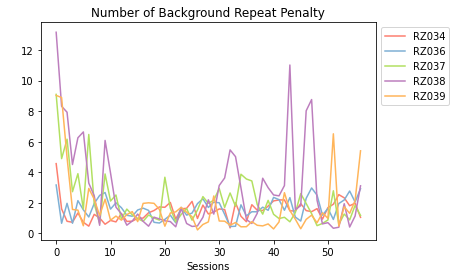

In [36]:
plot_each_mouse_per_line(data_df=mistakes_df, 
                         column_name='num_bg_repeats_mean', 
                         plot_name="num_bg_repeats_mean", 
                         title='Number of Background Repeat Penalty',
                         x_label='Sessions', 
                         y_label=' ')

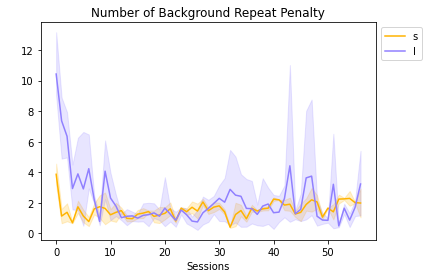

In [37]:
plot_overdays_colored_by_group(data_df=mistakes_df, 
                               column_name="num_bg_repeats_mean", 
                               plot_name='num_bg_repeats_mean_by_group', 
                               title='Number of Background Repeat Penalty', 
                               x_label='Sessions', 
                               y_label=' ')

### plot mistake rate

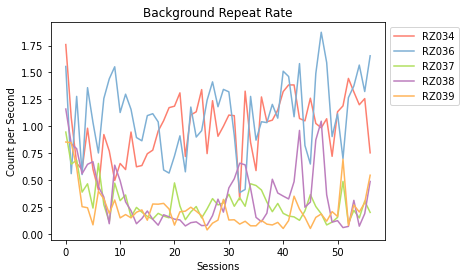

In [38]:
plot_each_mouse_per_line(data_df=mistakes_df, 
                         column_name='num_bg_repeats_rate_mean', 
                         plot_name="num_bg_repeats_rate_mean", 
                         title='Background Repeat Rate',
                         x_label='Sessions', 
                         y_label='Count per Second')

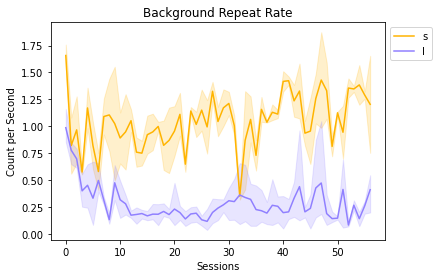

In [39]:
plot_overdays_colored_by_group(data_df=mistakes_df, 
                               column_name="num_bg_repeats_rate_mean", 
                               plot_name='num_bg_repeats_rate_mean_by_group', 
                               title='Background Repeat Rate', 
                               x_label='Sessions', 
                               y_label='Count per Second')

# Plot time wait behavior

### generate wait df for plotting

In [40]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session', 'dir', 'group']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c5.load_data(utils_c5.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [41]:
wait_df = generate_wait_df(sessions_training)

### plot time watied

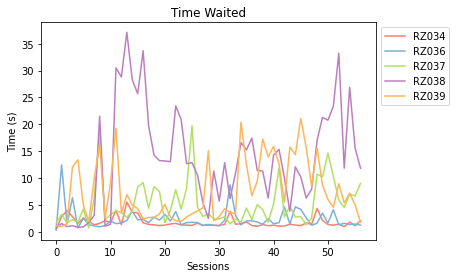

In [42]:
# plot the time waited over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean', 
                         plot_name="tw_mean", 
                         title='Time Waited',
                         x_label='Sessions', 
                         y_label='Time (s)')

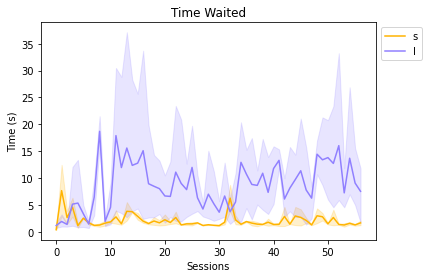

In [43]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean", 
                               plot_name='tw_mean_by_group', 
                               title='Time Waited', 
                               x_label='Sessions', 
                               y_label='Time (s)')

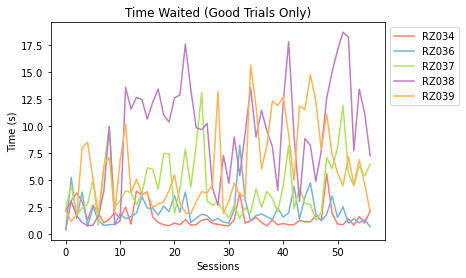

In [44]:
# plot the time waited over days good trials only. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean_g', 
                         plot_name="tw_mean_g", 
                         title='Time Waited (Good Trials Only)',
                         x_label='Sessions', 
                         y_label='Time (s)')

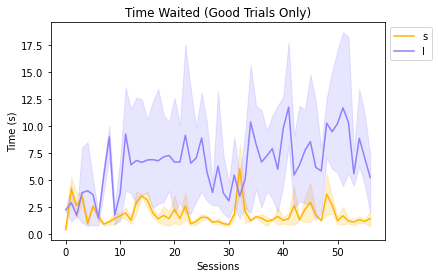

In [45]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean_g", 
                               plot_name='tw_mean_g_by_group', 
                               title='Time Waited (Good Trials Only)', 
                               x_label='Sessions', 
                               y_label='Time (s)')

## some stats

all sessions tw difference

In [46]:
short = wait_df[wait_df['group']=='s']
long = wait_df[wait_df['group']=='l']

print(short.tw_mean.mean())
print(long.tw_mean.mean())

#perform independent two sample t-test
stats.ttest_ind(short['tw_mean'], long['tw_mean'])

2.1207495783941965
8.797053596811622


Ttest_indResult(statistic=-9.264773853480174, pvalue=5.107636412541438e-18)

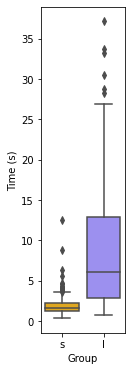

In [47]:
plt.figure(figsize=(1.5, 6))
sns.boxplot(data=wait_df, x="group", y="tw_mean", palette=custom_palette)
plt.ylabel("Time (s)")
plt.xlabel("Group")
plt.savefig(f'{figure_folder}/{"tw_box"}.png', bbox_inches='tight')

by days sessions tw difference

In [48]:
def generate_p_val_df(wait_df, group_col_name):
    result_list = []
    for num, data in wait_df.groupby(group_col_name):
        short = data[data['group']=='s']
        long = data[data['group']=='l']
        s_tw = short.tw_mean.mean()
        l_tw = long.tw_mean.mean()

        # Perform t-test
        ttest = stats.ttest_ind(short['tw_mean'], long['tw_mean'])
        p_val_t = ttest[1]

        # Perform Mann-Whitney U test
        u_test = stats.mannwhitneyu(short['tw_mean'], long['tw_mean'])
        p_val_u = u_test[1]

        result_list.append([num, s_tw, l_tw, p_val_t, p_val_u])

    return pd.DataFrame(result_list, columns=["num", "s_tw", "l_tw", "p_val_t", "p_val_u"])

In [49]:
tw_stats_by_session = generate_p_val_df(wait_df, "session")

In [50]:
tw_stats_by_session[tw_stats_by_session['p_val_t'] < 0.05]

,num,s_tw,l_tw,p_val_t,p_val_u
8,8,1.295409,18.711062,0.003088,0.2
41,41,1.416483,13.316854,0.003231,0.2
48,48,3.016110,14.455560,0.023227,0.2


plot waiting df in 10 day intervals

In [51]:
wait_df['period'] = wait_df['session']//10 #add session period in 10 day intervals

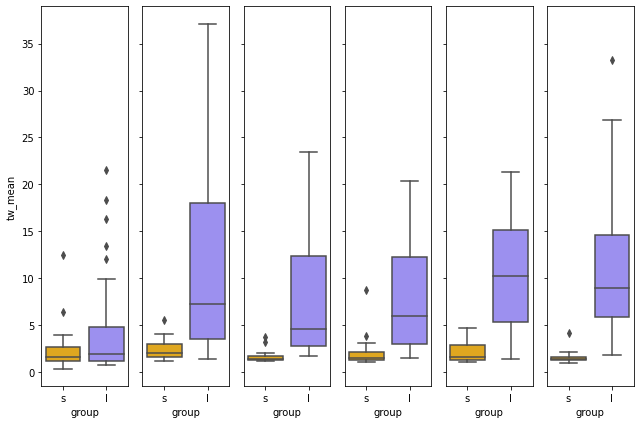

In [52]:
num_subplots = wait_df['period'].max()+1
fig, axs = plt.subplots(1, num_subplots, figsize=(num_subplots*1.5, 6), sharey=True)
for p, period_data in wait_df.groupby('period'):
    sns.boxplot(data=period_data,
                x="group", 
                y="tw_mean", 
                palette=custom_palette,
                ax=axs.flat[p])
    if p != 0:
        axs.flat[p].set_ylabel("")

plt.tight_layout()
plt.savefig(f'{figure_folder}/tw_box_by_period.png', bbox_inches='tight')

In [53]:
tw_stats_by_period = generate_p_val_df(wait_df, "period")
tw_stats_by_period[tw_stats_by_period['p_val_t'] < 0.05]

,num,s_tw,l_tw,p_val_t,p_val_u
1,1,2.409639,11.591615,4.813824e-04,4.553287e-06
2,2,1.662751,7.628900,9.429369e-05,5.451747e-08
3,3,2.129433,7.922303,5.759234e-05,1.569196e-06
4,4,2.219728,10.253766,1.134356e-07,2.485475e-07
5,5,1.654661,11.467832,1.051201e-04,1.352387e-06


In [54]:
tw_stats_by_period

,num,s_tw,l_tw,p_val_t,p_val_u
0,0,2.508459,4.719138,1.182437e-01,3.172868e-01
1,1,2.409639,11.591615,4.813824e-04,4.553287e-06
2,2,1.662751,7.628900,9.429369e-05,5.451747e-08
3,3,2.129433,7.922303,5.759234e-05,1.569196e-06
4,4,2.219728,10.253766,1.134356e-07,2.485475e-07
5,5,1.654661,11.467832,1.051201e-04,1.352387e-06


## plots to be figured out

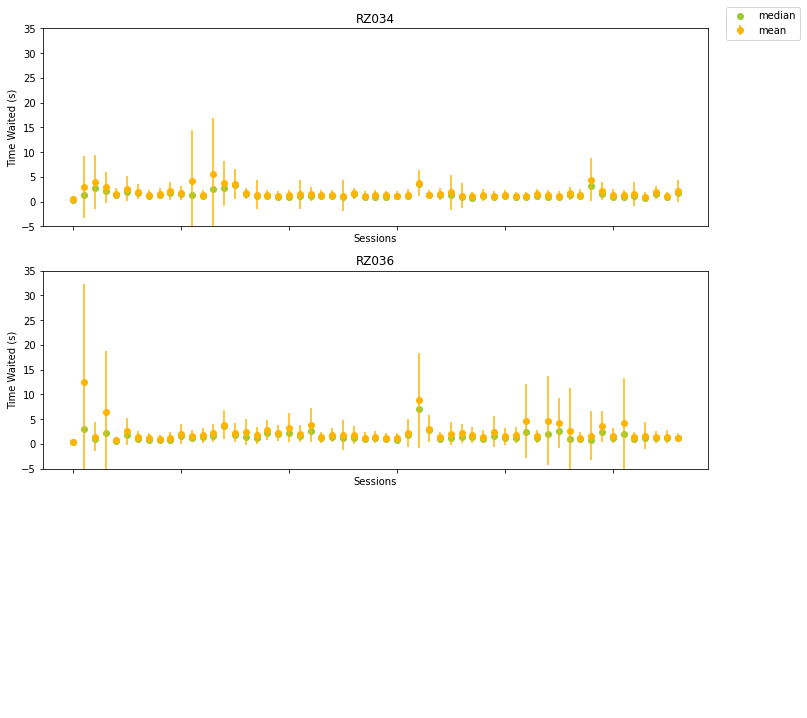

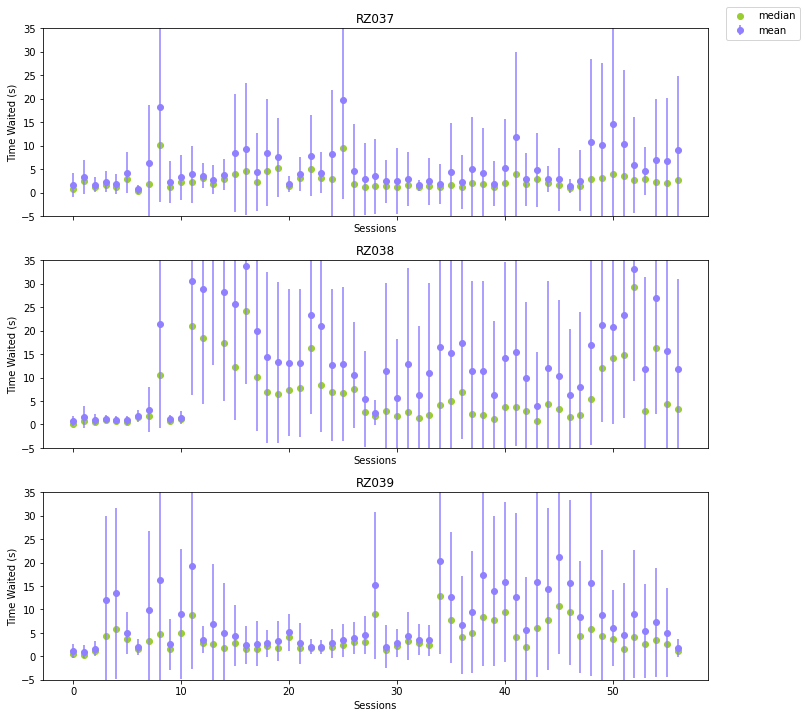

In [57]:
for group, mice in cohort_group.items():
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)
    for i, mouse in enumerate(mice):
        session_mouse = wait_df.loc[(wait_df.mouse == mouse) & (wait_df.group == group)]
        ax = axs.flat[i]
        ax.errorbar(session_mouse.session, session_mouse.tw_mean, session_mouse.tw_stdev, 
                    linestyle='None', marker='o', color=custom_palette[group], label='mean')
        ax.scatter(session_mouse.session, session_mouse.tw_median, label='median', color='yellowgreen')
        ax.set_title(mouse)
        ax.set_xlabel('Sessions')
        ax.set_ylabel('Time Waited (s)')
        ax.set_ylim([-5, 35])
    
    if group == "s":
        axs.flat[2].axis('off')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/tw_plots_{group}.png', bbox_inches='tight', dpi=300)

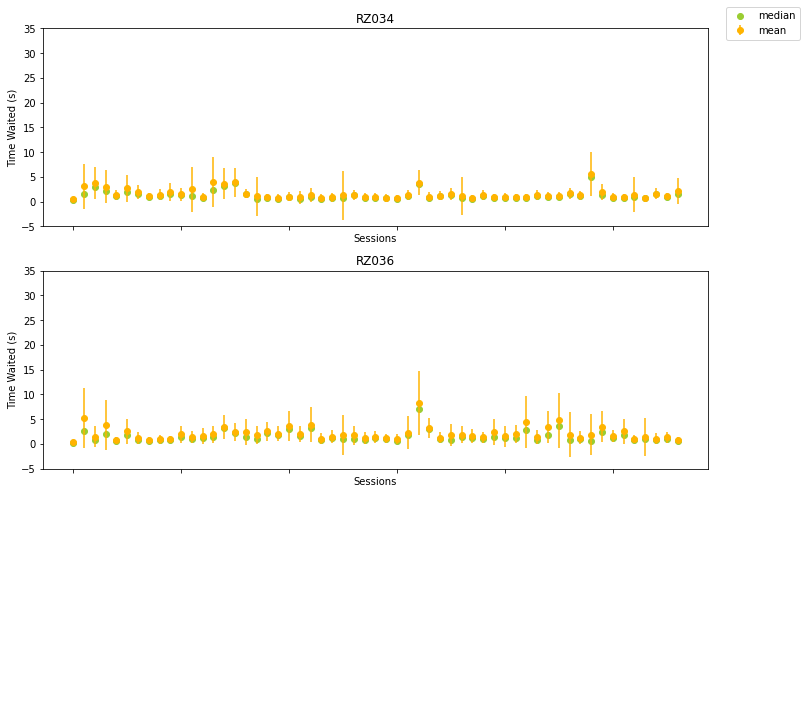

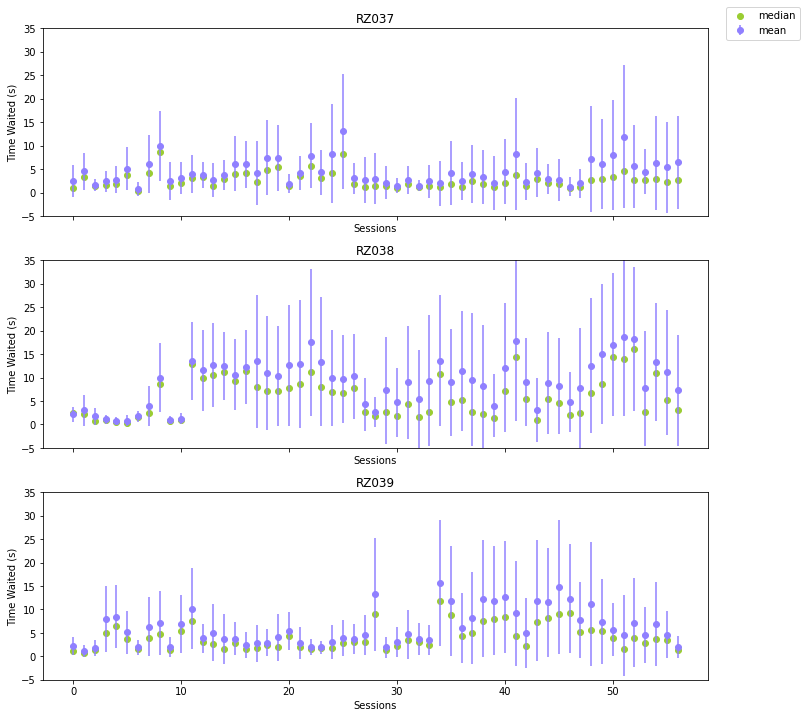

In [58]:
for group, mice in cohort_group.items():
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)
    for i, mouse in enumerate(mice):
        session_mouse = wait_df.loc[(wait_df.mouse == mouse) & (wait_df.group == group)]
        ax = axs.flat[i]
        ax.errorbar(session_mouse.session, session_mouse.tw_mean_g, session_mouse.tw_stdev_g, 
                    linestyle='None', marker='o', color=custom_palette[group], label='mean')
        ax.scatter(session_mouse.session, session_mouse.tw_median_g, label='median', color='yellowgreen')
        ax.set_title(mouse)
        ax.set_xlabel('Sessions')
        ax.set_ylabel('Time Waited (s)')
        ax.set_ylim([-5, 35])
    
    if group == "s":
        axs.flat[2].axis('off')
        # axs.set_ylim(0, 35)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/tw_good_plots_{group}.png', bbox_inches='tight', dpi=300)

In [59]:
def calculate_subplot_row_col(session_mouse, plots_per_row):
    days_trained = len(session_mouse)
    num_rows = (days_trained - 1) // plots_per_row + 1
    num_cols = min(days_trained, plots_per_row)
    return num_rows, num_cols

In [60]:
for mouse in mouse_list:
    session_mouse = sessions_training.loc[sessions_training.mouse == mouse]
    num_rows, num_cols = calculate_subplot_row_col(session_mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(21.5, 2.5 * num_rows))

    for i, (_, session_info) in enumerate(session_mouse.iterrows()):
        all_trials = utils_c5.load_data(utils_c5.generate_trials_analyzed_path(data_folder, session_info))
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="group",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_ylim([0,35])
        ax.set_title(f'Session {i}')
        ax.legend().remove()
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)
    plt.close()

# Stitched all sessions all mice per day

In [60]:
stitched_folder = os.path.join(data_dir, cohort, exp, 'stitched')
stitched_figure_folder = os.path.join(data_dir, cohort, exp, 'figures')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/data/behavior_data/cohort_5/exp2/full_clean
/Users/rebekahzhang/data/behavior_data/cohort_5/exp2/figures


In [61]:
stitched_log = utils.load_session_log(stitched_folder, f'sessions_training_stitched_{exp}.csv')

In [62]:
def generate_events_processed_stitched_path(data_folder, session_info):
    filename = f'events_processed_stitched_{session_info.date}.csv'
    return os.path.join(data_folder, f"{session_info.date}", filename)

In [63]:
def generate_trials_analyzed_stitched_path(data_folder, session_info):
    filename = f'trials_analyzed_stitched_{session_info.date}.csv'
    return os.path.join(data_folder, session_info.date, filename)

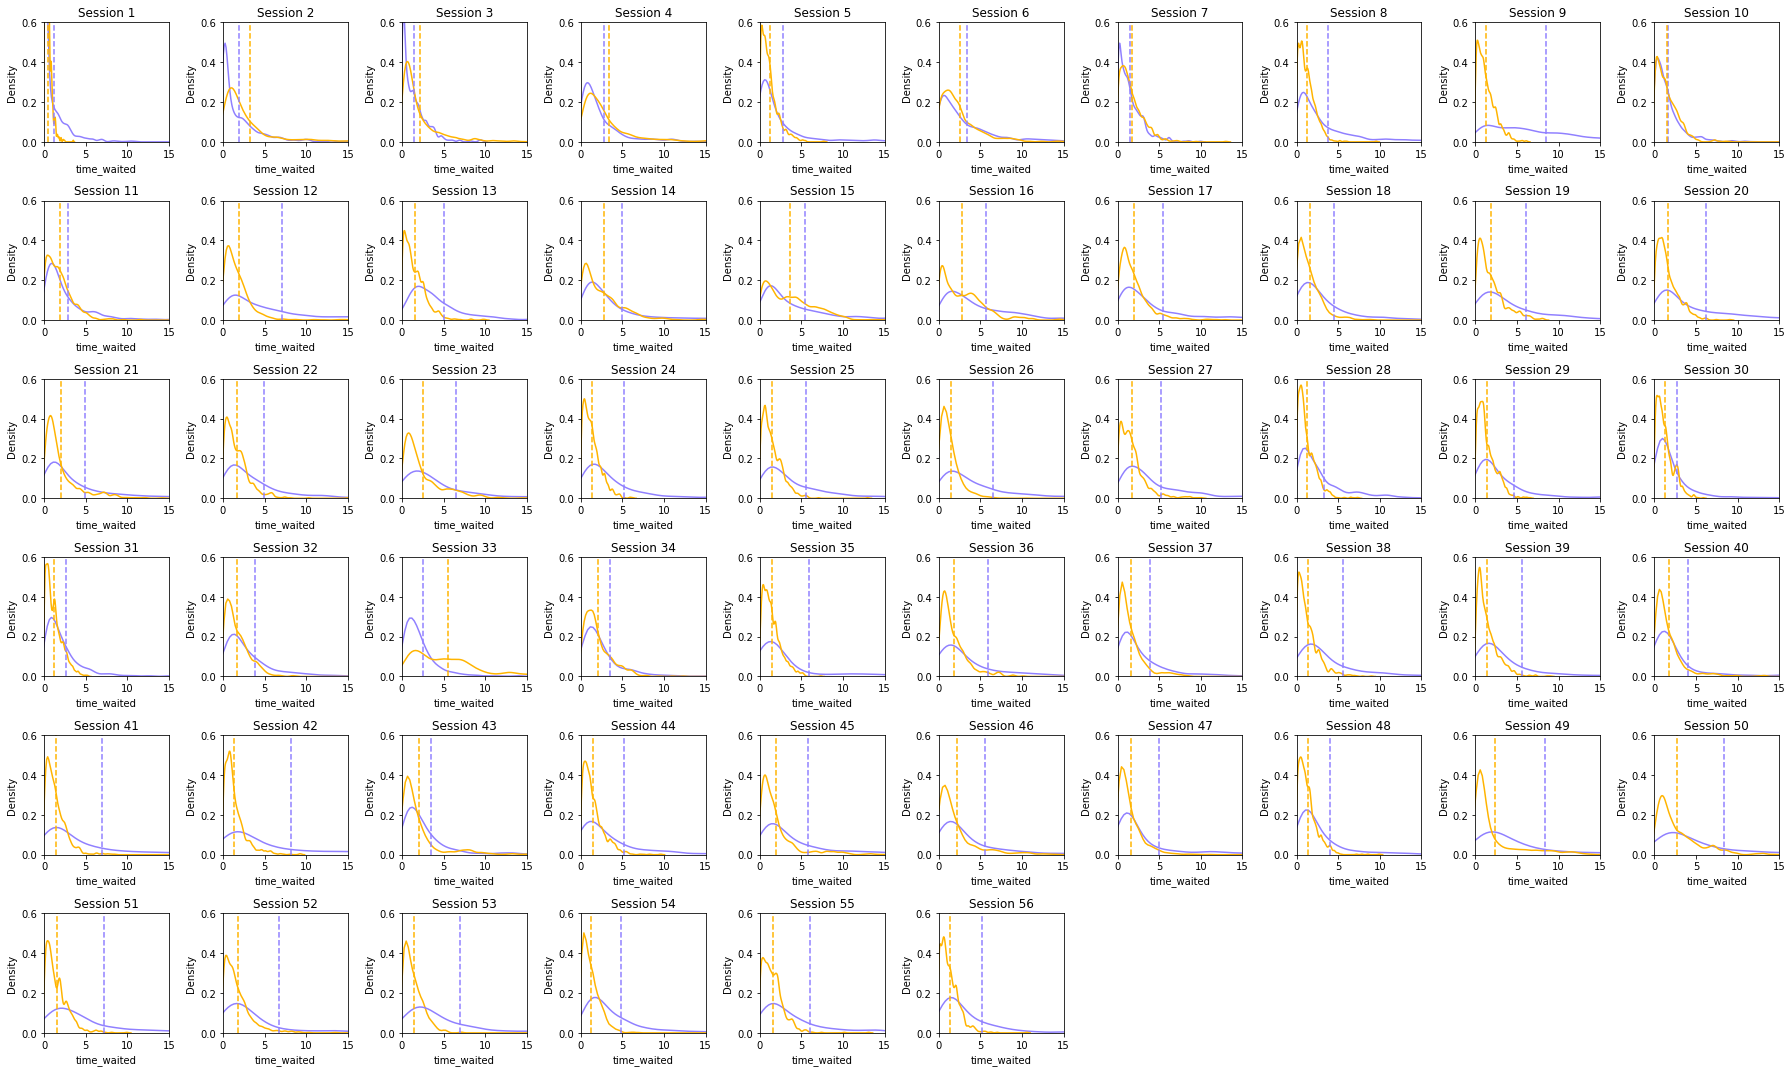

In [64]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 10 + 1
num_cols = min(days_trained, 10)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(2.5*num_cols, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c5.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=all_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=all_trials.loc[all_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=all_trials.loc[all_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 0.6])
    ax.set_title(f'Session {i+1}')
    
# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_kde.png', bbox_inches='tight', dpi=300)

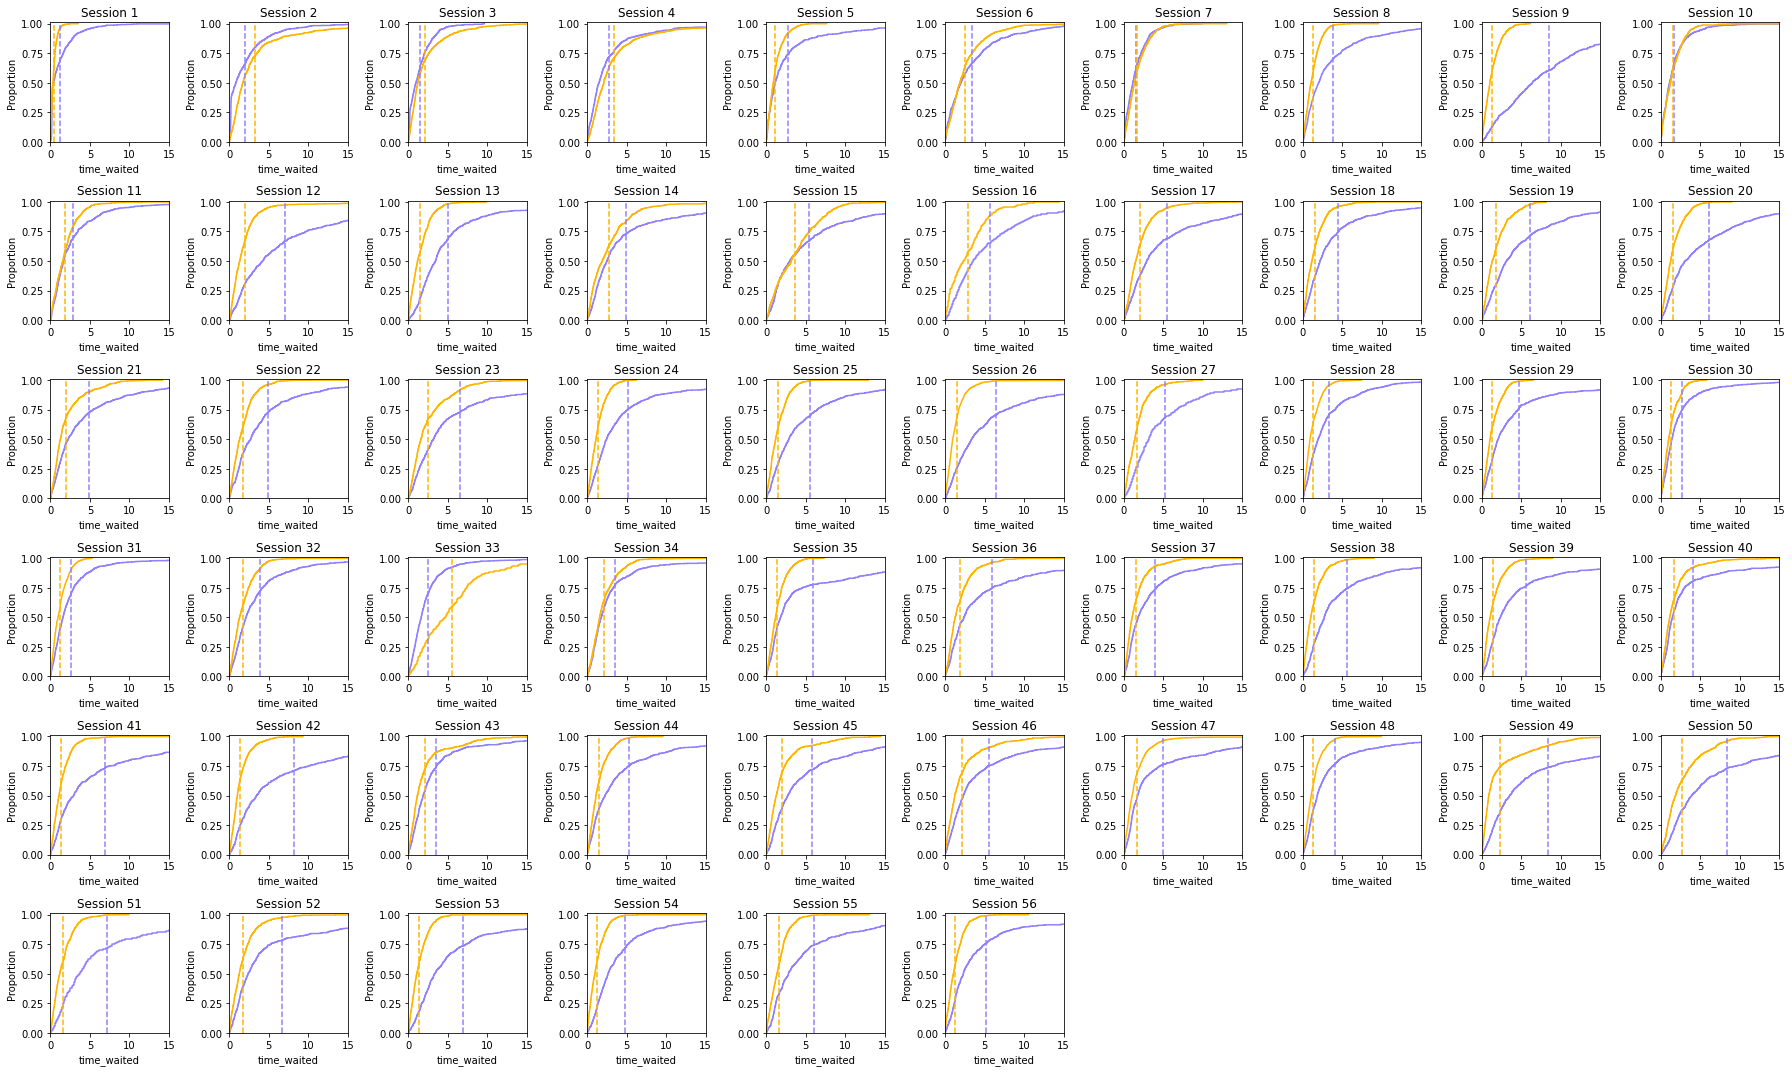

In [65]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 10 + 1
num_cols = min(days_trained, 10)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(2.5*num_cols, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c5.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.ecdfplot(data=all_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=all_trials.loc[all_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=all_trials.loc[all_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 1.01])
    
    ax.set_title(f'Session {i+1}')
    
# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_cdf.png', bbox_inches='tight', dpi=300)

In [66]:
def select_non_accident_trials(all_trials):
    non_accident_trials = all_trials[all_trials['time_waited'] > 0.5]
    return non_accident_trials

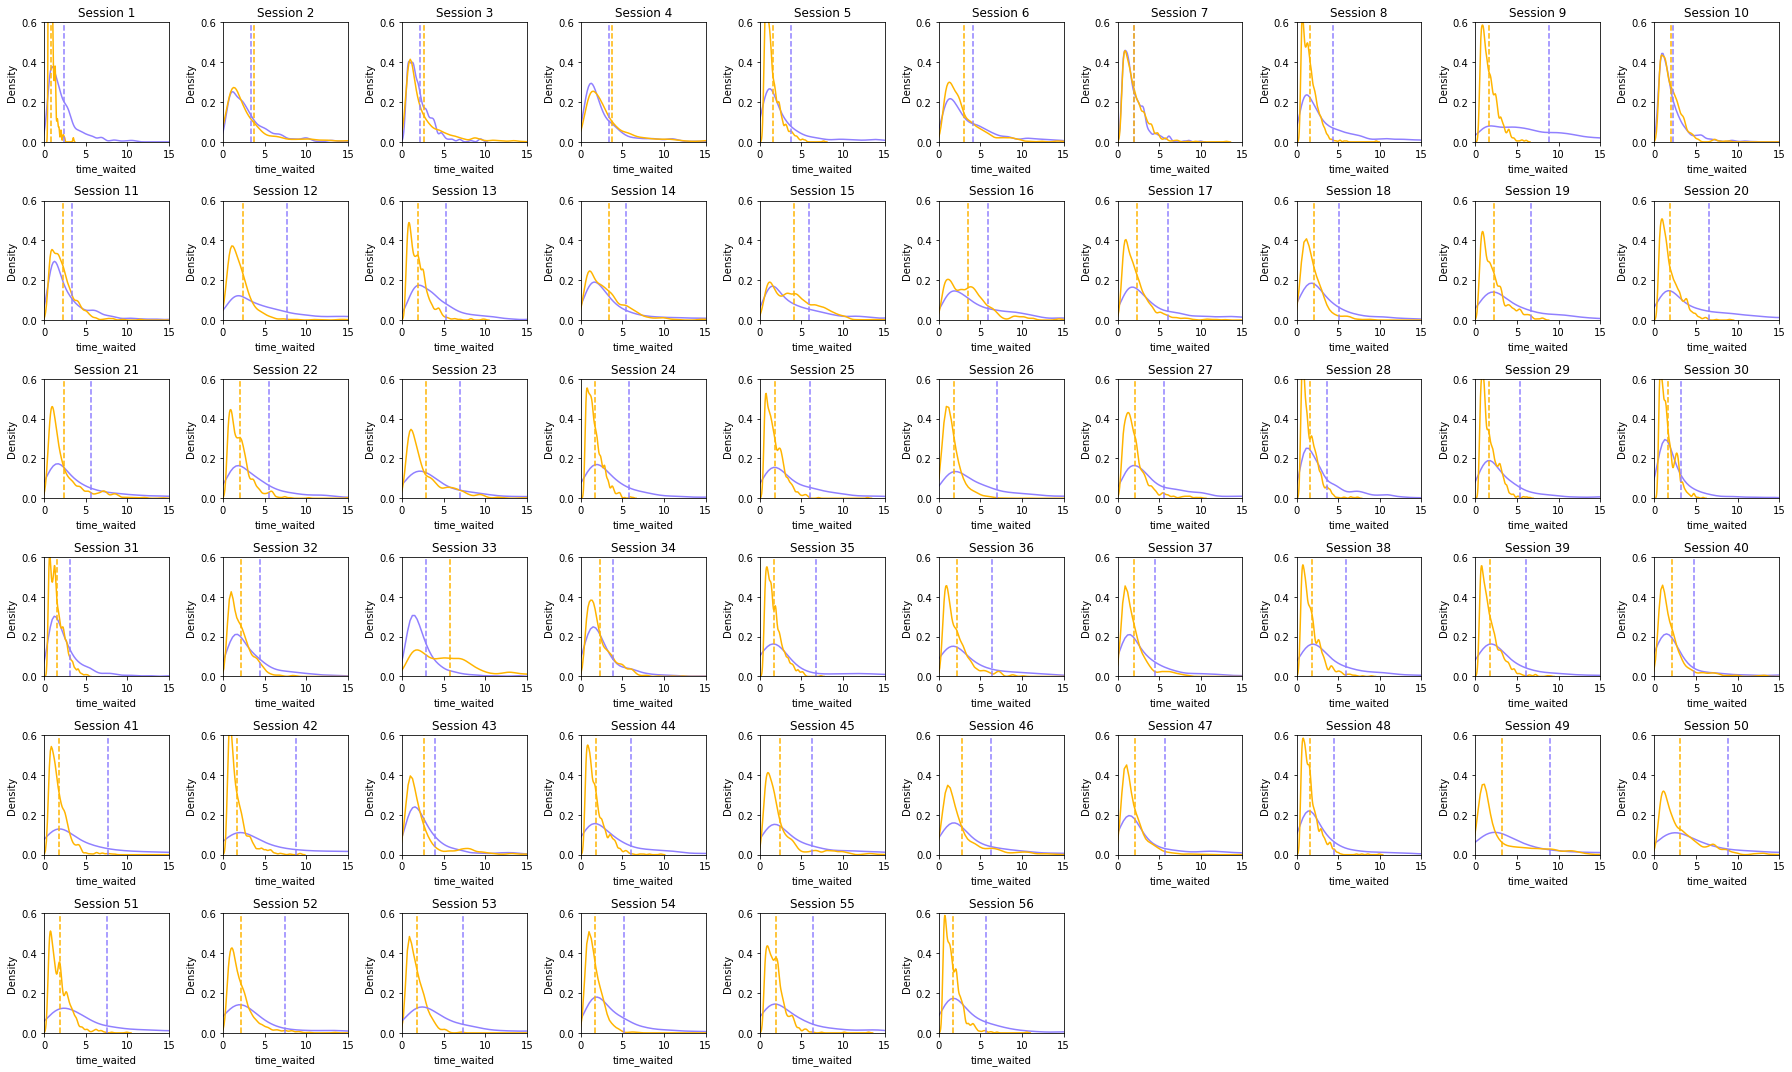

In [67]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 10 + 1
num_cols = min(days_trained, 10)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(2.5*num_cols, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c5.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    non_accident_trials = select_non_accident_trials(all_trials)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=non_accident_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 0.6])
    
    ax.set_title(f'Session {i+1}')

# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_g_kde.png', bbox_inches='tight', dpi=300)

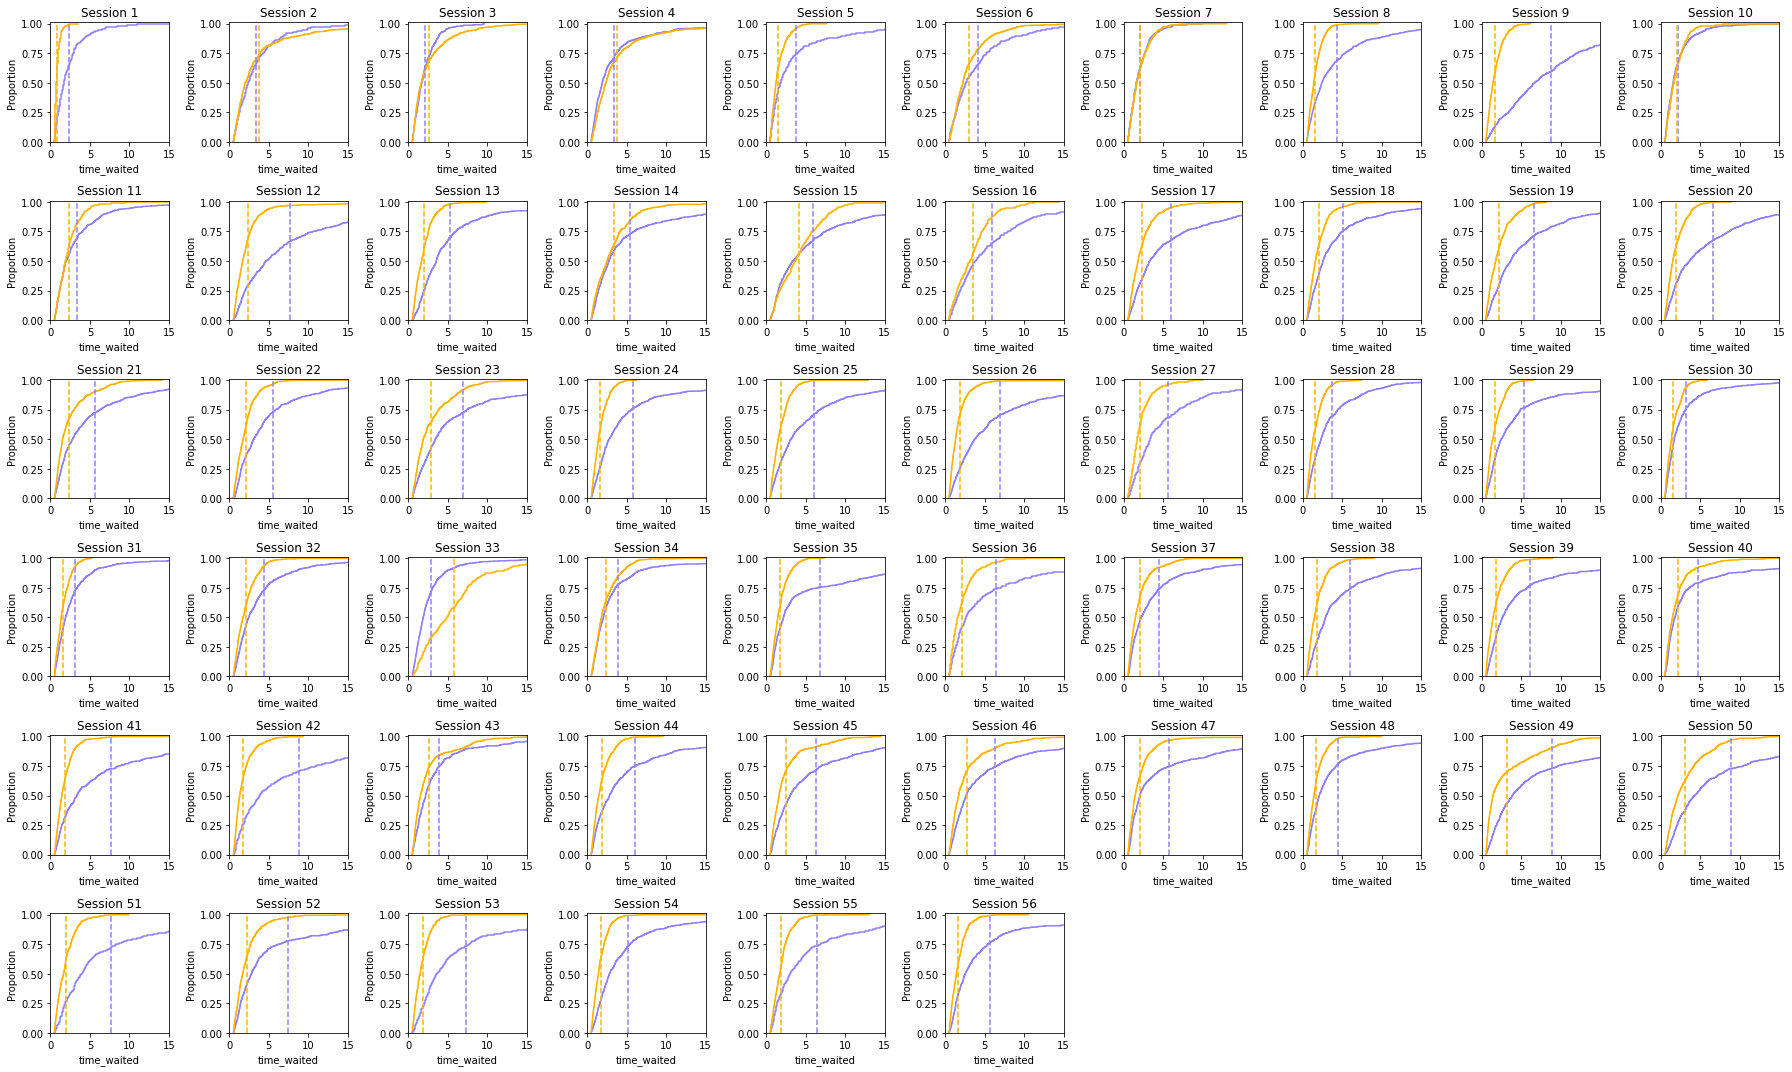

In [68]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 10 + 1
num_cols = min(days_trained, 10)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(2.5*num_cols, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c5.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    non_accident_trials = select_non_accident_trials(all_trials)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.ecdfplot(data=non_accident_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 1.01])
    
    ax.set_title(f'Session {i+1}')

# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_g_cdf.png', bbox_inches='tight', dpi=300)